# Tutorial to Generate Ambient Contamination Metric Plots

In [1]:
#import packages
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from matplotlib import pyplot as plt

In [2]:
import AmbiQuantFunctions as abq

- example dataset in the notebook can be downloaded:
    + dropset files:
    <br>```mkdir 5394_YX_2``` (make a folder for the files)
    <br>```cd 5394_YX_2 ``` (change directory to the folder) 
    <br>```curl -O -J -L https://www.dropbox.com/sh/1z2nc7v3pp9o286/AACdWSa5uswk1pBLVn9yjhDna?dl=0 ``` (download as a zip file) 
    <br>```unzip 5394_YX_2.zip``` (unzip)
    + h5ad file:
    <br>```curl -O -J -L https://www.dropbox.com/s/s2h2t5uyd9ygud3/5394_YX_2_full.h5ad?dl=0```

In [9]:
!curl -O -J -L https://www.dropbox.com/s/s2h2t5uyd9ygud3/5394_YX_2_full.h5ad?dl=0

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   136  100   136    0     0    632      0 --:--:-- --:--:-- --:--:--   632
100    17  100    17    0     0     23      0 --:--:-- --:--:-- --:--:--    34
100   491    0   491    0     0    335      0 --:--:--  0:00:01 --:--:--     0
100 36.9M  100 36.9M    0     0  14.1M      0  0:00:02  0:00:02 --:--:-- 82.5M


## Step1: cut-off the dataset so that the number of barcodes included in the analysis is around 4x of estimated real cell number in the dataset
- need to cut off the dataset because there will usually be a large and varied number of empty droplets in each dataset
- set the barcode size to 4* inflection point is a recommanded choice
- inflection point found by a QCPipe function, supposed to be an estimate cut line distinguishing between empty droplets and real cells based on total transcript counts

### Option 1: Read dropset data (gene names, barcodes and count matrix) into an anndata object and cut-off the anndata object

#### cut_off_from_dropset() function usage: 
- dir_path should be the path to a directory that contains 3 essential files: count matrix, a list of gene names and a list of barcodes 
- identifiers are keywords naming the gene and barcode list files in the dropset folder
- delim (delimiter) as specified in pandas' read_csv function ('\t' for tsv, ',' for csv). It is used to read the gene and barcode list files
- var/obs col need to be set if the feature/gene name or barcode file has more than one columns. Should be a 0-based integer index
    - eg. gene name files some times consist of ensembl ID and gene name in 2 columns 
    - in this case, set the number as the column number to be used 
- inflection_fold is used to specify how many total cells will be kept in the analysis as mentioned above if est_real_cell is set to None
- or the user can manually set an integer to est_real_cell, which is the expected number of real cells captured in this dataset
- max_cell number is the hard cut-off of total number of cell kept for the analysis: always keep no more than this number regardless of inflection point or estimate real cell number
    - low-quality datasets sometimes get a high estimated real cell number than expected, so they end up keep max_cell number of cells instead of 4x estimated real cell
- mito_tag: prefix of feature/gene names for mitochondrial genes. Use 'MT-' for human sample or 'mt-' for mice sample

for more detail, read the function header 

In [3]:
#specify the directory where the data stores 
dat_path = "./5394_YX_2/"

Calculating QC Metrics
Inflection point at [ 7197 11558 15920] for [0, 15, 30] percentiles of greatest secant distances
the original dataset has 36277 cells. Cut to 10000 cells


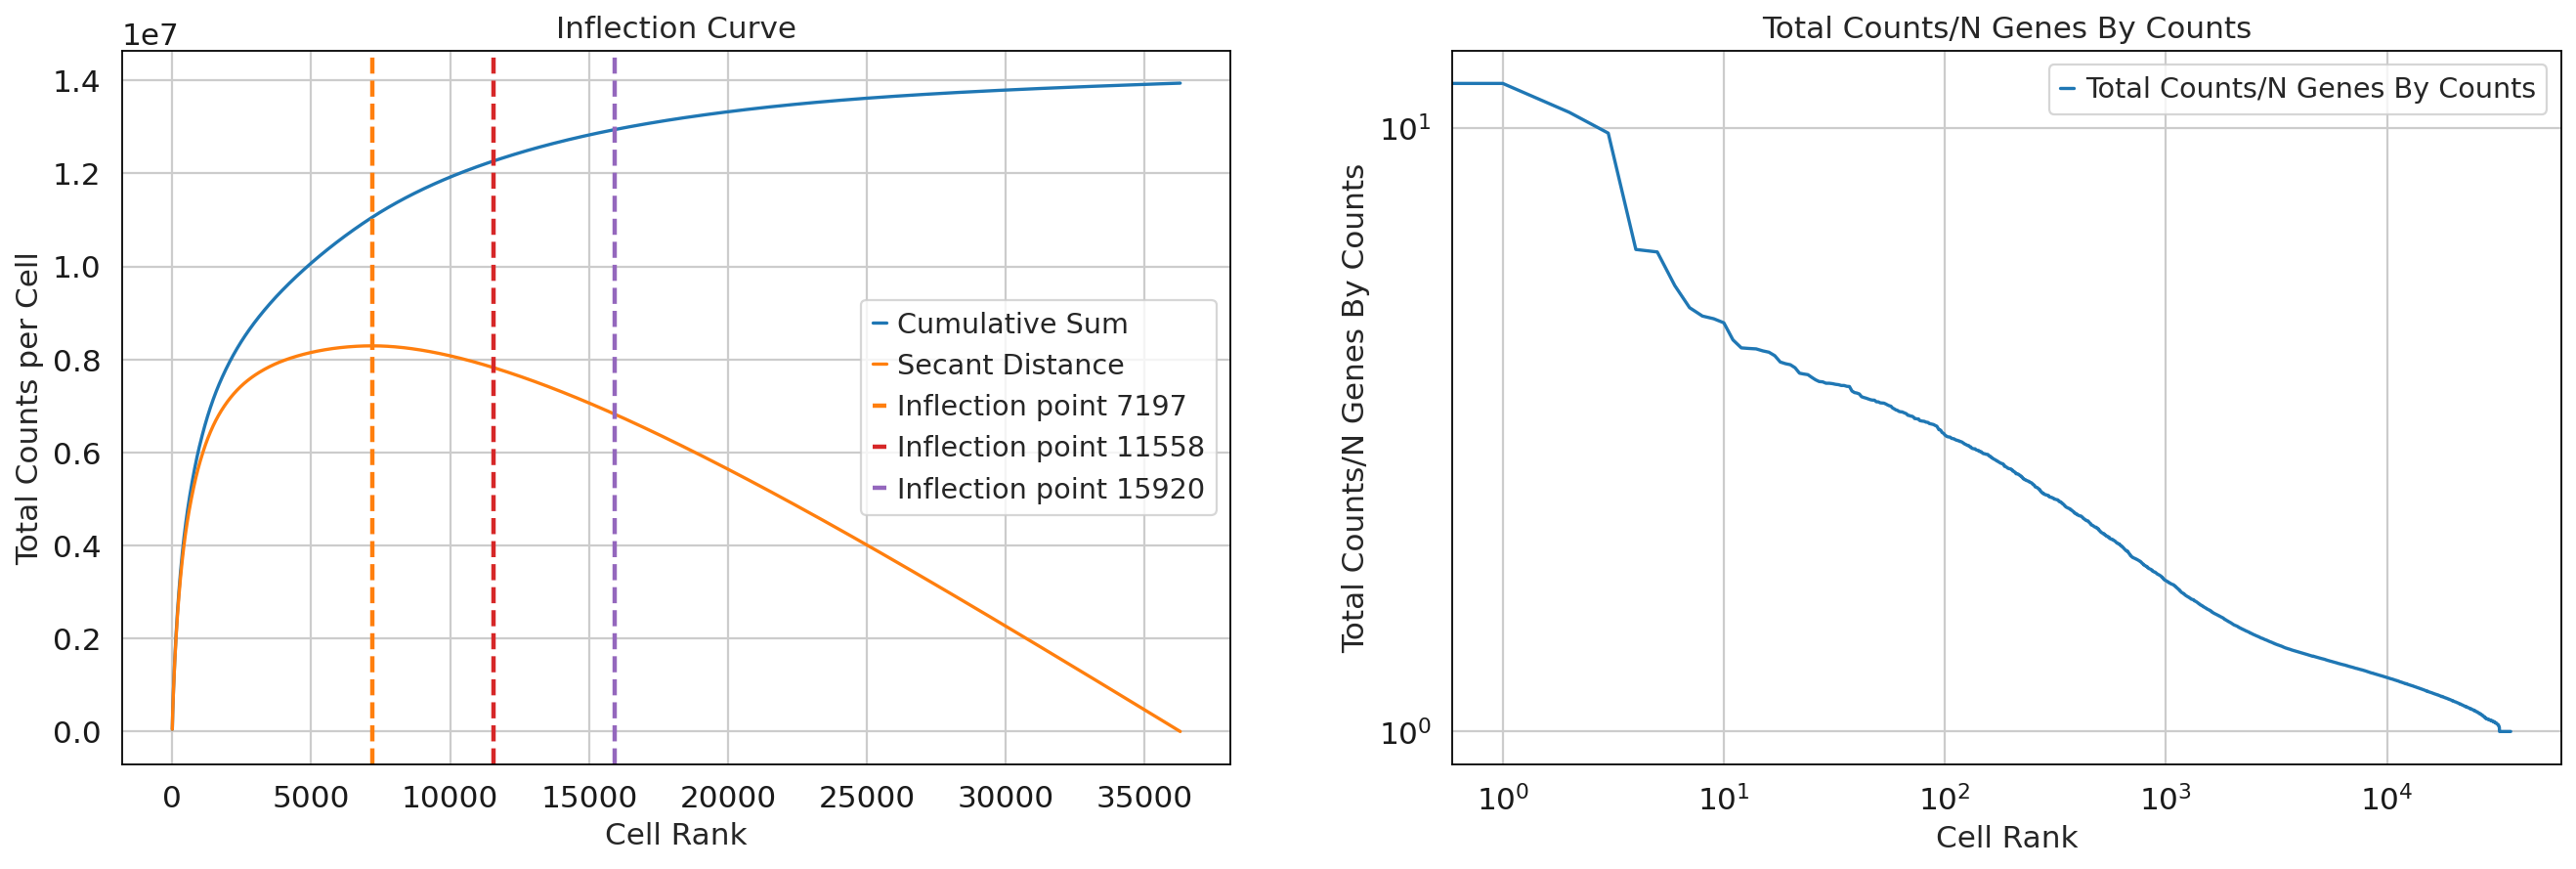

In [4]:
dat = abq.cut_off_from_dropset( data_path = dat_path, 
                         gene_file_identifier = "features", barcode_file_identifier = "barcodes",
                         gene_file_delim = ',', barcode_file_delim = ',',
                         var_col = 0, obs_col = 0, 
                         inflection_fold = 4, est_real_cell= None, max_cell = 10000, 
                         mito_tag = "mt-",run_qc=True, print_info = True)


In [14]:
#check if read-in properly 
dat.to_df().head()

Genes,Xkr4,Mrpl15,Tcea1,Sntg1,Cops5,Cspp1,Tram1,Rpl7,Tceb1,Tmem70,...,Upk3a,1700120G07Rik,Gm4775,Tmem136,Retnla,Hyal4,Gpnmb,Acsm2,2610305D13Rik,Gm10701
Cells,,,,,,,,,,,,,,,,,,,,,
AGGTGACACAGCACCAC,1.0,5.0,4.0,2.0,4.0,0.0,11.0,157.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GACCCGAATGATATAGGA,1.0,3.0,1.0,3.0,2.0,1.0,15.0,140.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TAGCCTCGTAAGACGG,0.0,8.0,6.0,1.0,5.0,2.0,4.0,101.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TGACAAGTCATAGTGATGC,0.0,6.0,0.0,1.0,2.0,0.0,8.0,87.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TGAGGCTACTAATACTCTT,0.0,8.0,0.0,2.0,0.0,2.0,9.0,57.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
dat

View of AnnData object with n_obs × n_vars = 10000 × 18476
    obs: 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mitochondrial', 'log1p_total_counts_Mitochondrial', 'pct_counts_Mitochondrial'
    var: 'Mitochondrial', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'Order', 'inflection1', 'inflection_fold'

### Option 2: Cut-off from h5ad files
- the h5ad file should be made from the raw count matrix before any filtering step

In [3]:
#read in data
dat = sc.read("./5394_YX_2_full.h5ad")

Calculating QC Metrics
Inflection point at [ 7197 11558 15920] for [0, 15, 30] percentiles of greatest secant distances
the original dataset has 36277 cells. Cut to 10000 cells


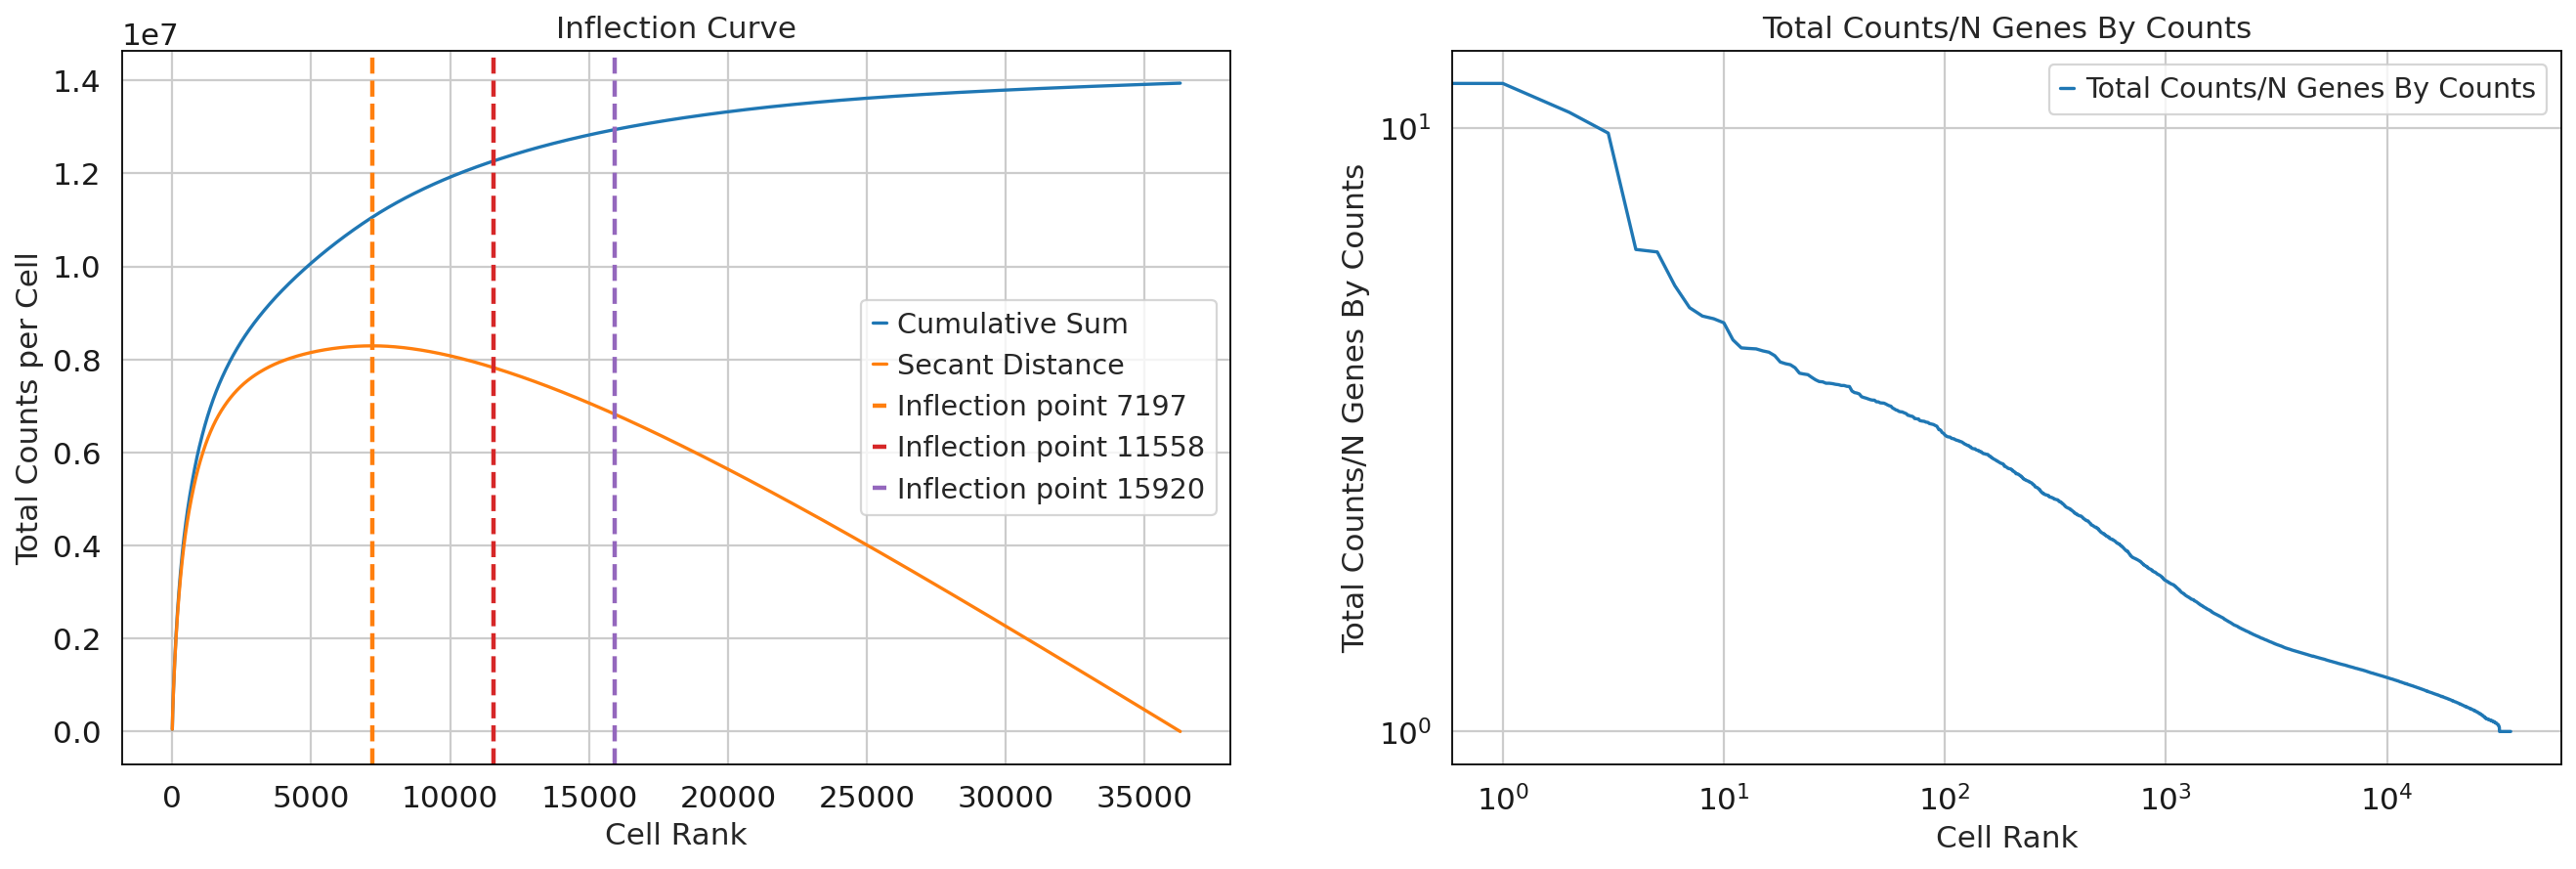

In [4]:
#cut off the dataset so that the total number of cells is 4x estimated real cell number or no more than max_cell number of cells
dat = abq.cut_off_h5ad(dat, inflection_fold = 4, est_real_cell = None, max_cell = 10000, 
                 qc_pipe_inflection = True, mito_tag = "mt-",run_qc=True, 
                 print_info = True)

## Step2: Generate the metric plots

/home/lucy/revise_AmbiQuant/AmbiQuant/plot_quality_score.py:266: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  sample_dat.var["pct_dropout_by_counts"] = np.array(


Top 1 ambient genes have dropout rates between 0.59 and 0.59 percent:
	['Car1']
Overall score: 0.4437302606059643


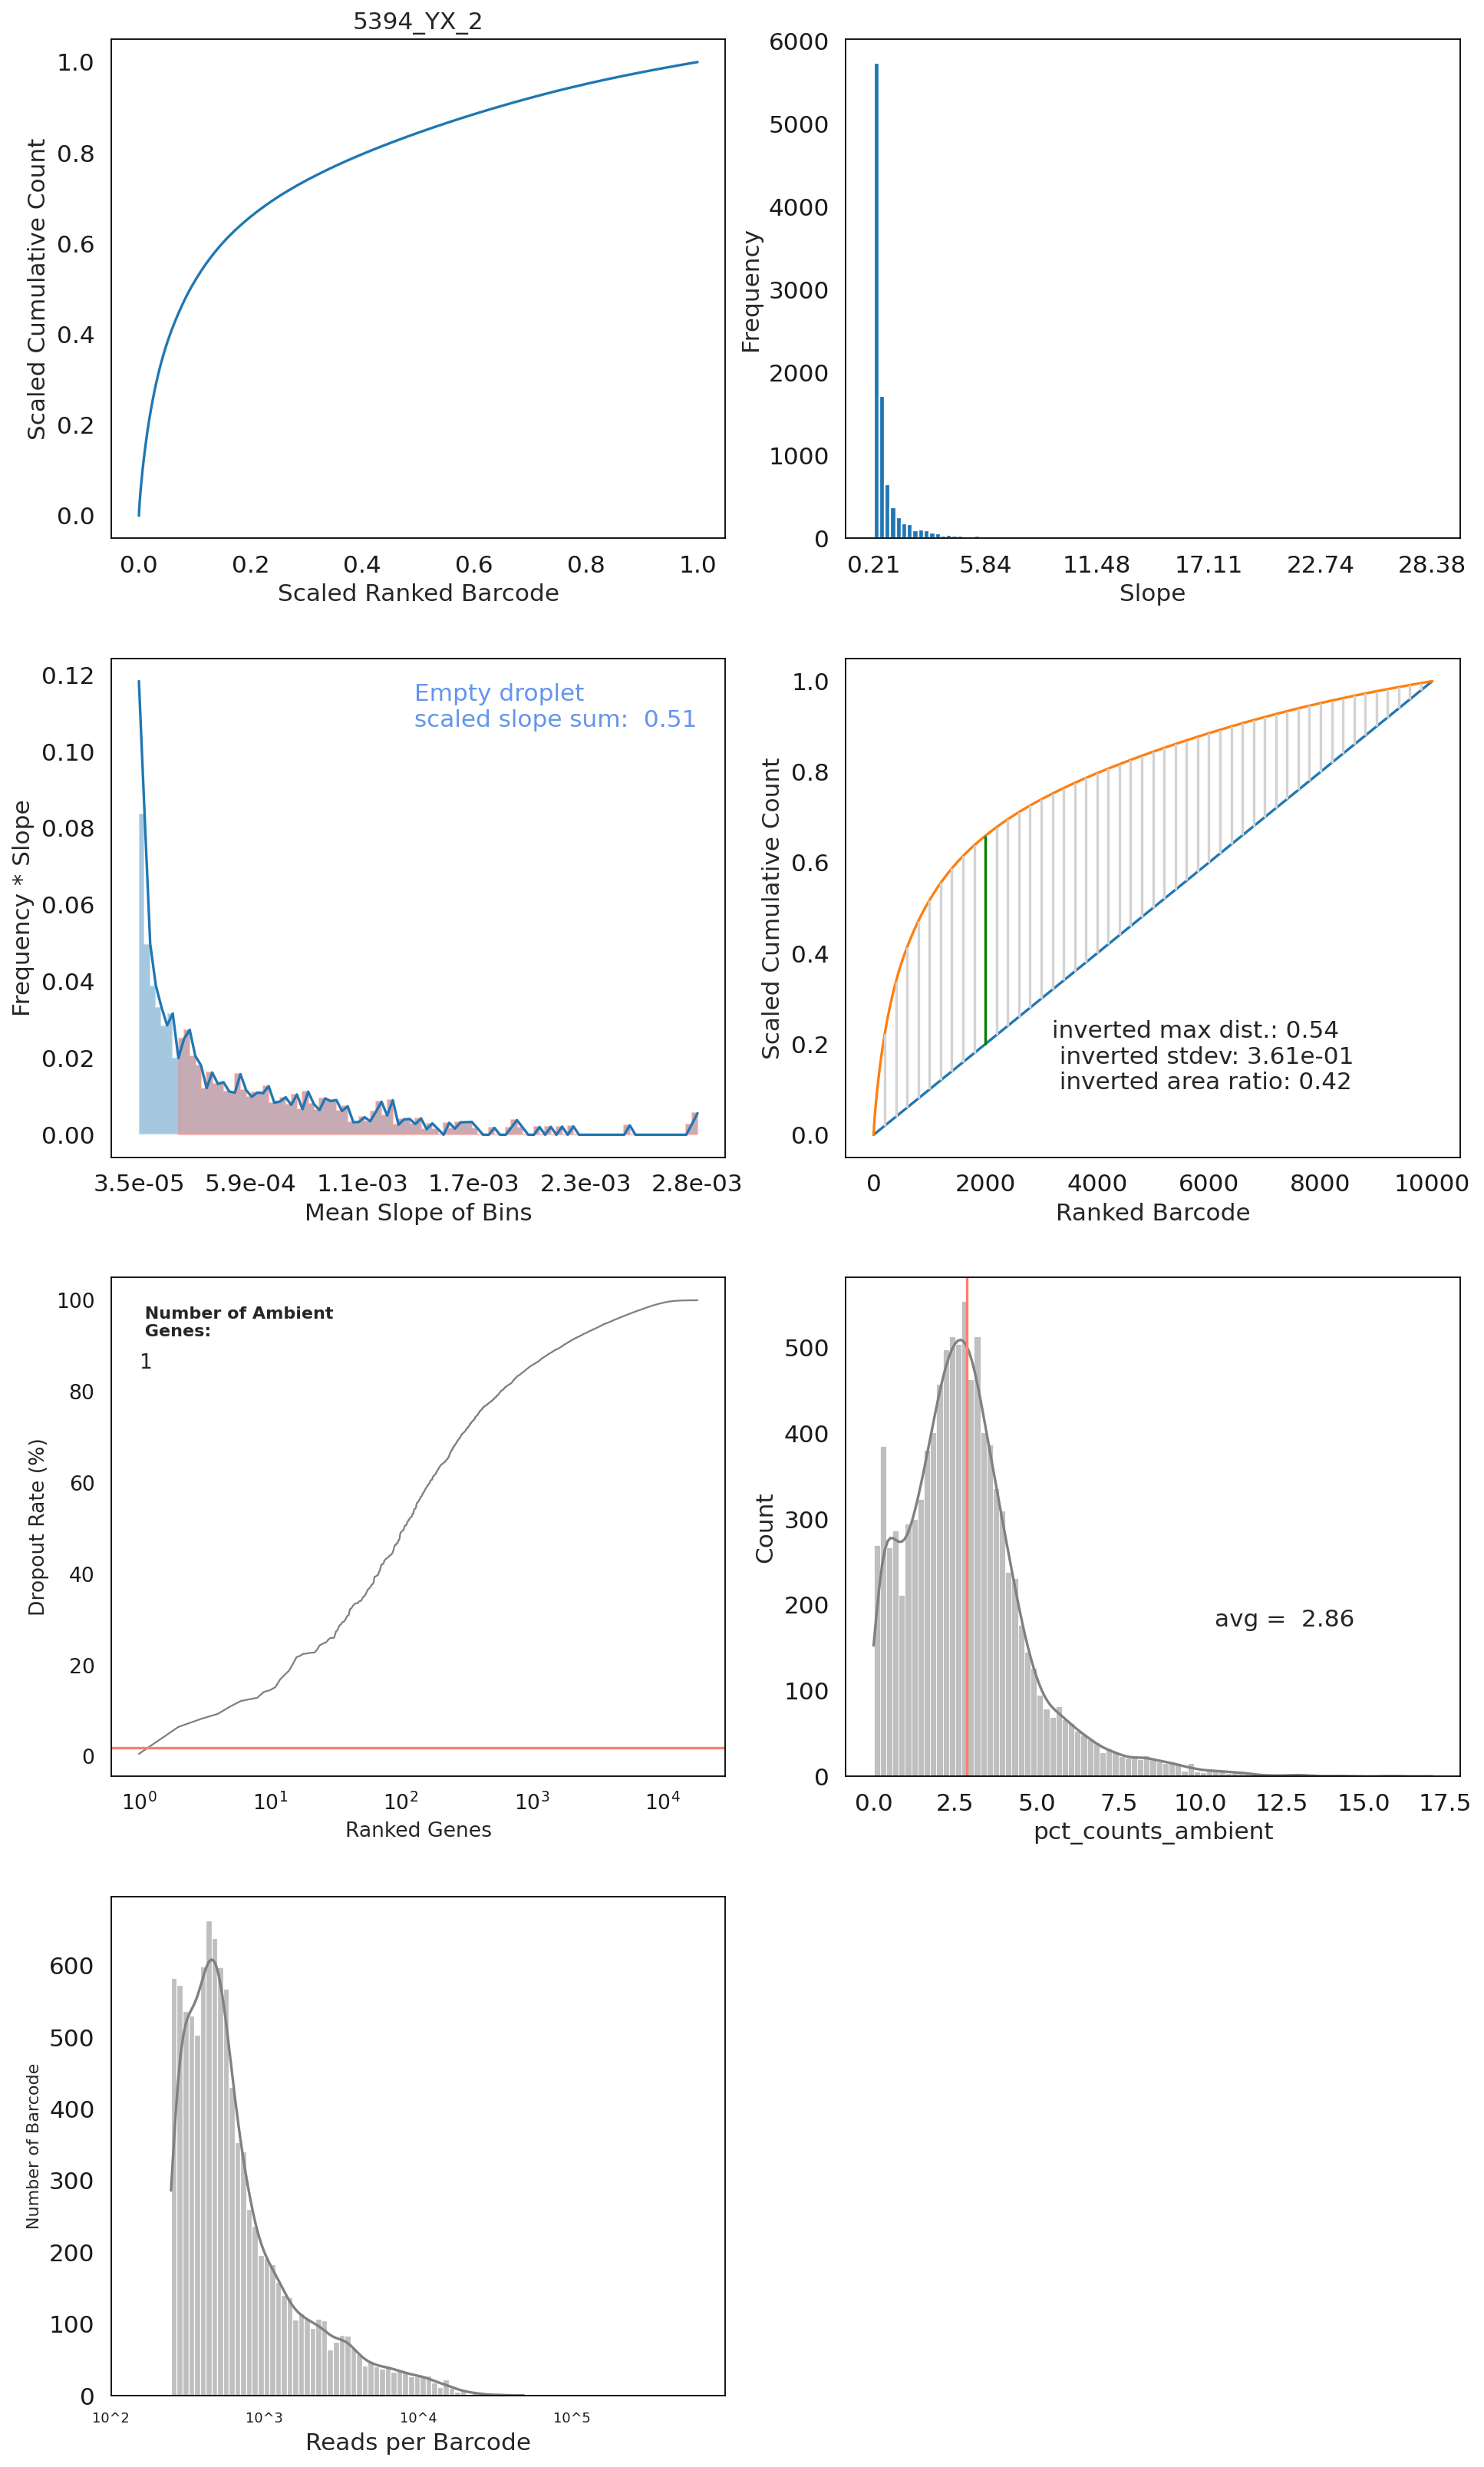

In [5]:
#detailed documentation can be found in the function header

#save_amb_ls and save_fig can be used to save the list of ambient gene and the plots. They should be strings of destination pathnames where the list and plot are saved

ret = abq.formatted_figures_inverted(dat, save_amb_ls = None, 
                      save_fig = None, show_dat_name = "5394_YX_2", invert_scores = True, ncols=2)

the function also return the numerical results that can be saved in csv or for other use

the **returned list is fomatted** as: 

[ <emsp> inverted high slope area (AKA empty droplet scaled slope sum),<br>
inverted max dist (AKA inverted max secant line distance),<br> 
inverted stdev (AKA inverted secant line stdev),<br> 
inverted area ratio (AKA inverted AUC),<br> 
number of ambient genes,<br>
average pct_count_ambient,<br> 
the anndata object  ]

- <font color = 'red'>the higher the values, the higher ambient RNA contamination level in the dataset </font>

In [6]:
print( ret[0:-1] )#first 6 elements are numerical results

[0.5084614877414424, 0.5408826393127442, 0.36064630279767385, 0.4193797551642229, 1, 2.8634815]


one **overall score** can also be output

In [8]:
abq.calc.overall_score(ret, from_formatted_figures = True)

0.4437302606059643

## (optional) Save the cut-h5ad

In [25]:
exp_name = '5394_YX_2'
dat.write(exp_name + "_cut.h5ad", compression = 'gzip')